In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
import os
import matplotlib.pyplot as plt

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Define the shared folder path in Google Drive
shared_folder_path = '/content/drive/MyDrive/DATASCI 207 Project/data'

# Paths for each file
X_train_path = os.path.join(shared_folder_path, 'X_train.npy')
y_train_path = os.path.join(shared_folder_path, 'y_train.npy')
X_val_path = os.path.join(shared_folder_path, 'X_val.npy')
y_val_path = os.path.join(shared_folder_path, 'y_val.npy')
X_test_path = os.path.join(shared_folder_path, 'X_test.npy')
y_test_path = os.path.join(shared_folder_path, 'y_test.npy')

# Load the datasets
X_train = np.load(X_train_path)
y_train = np.load(y_train_path)
X_val = np.load(X_val_path)
y_val = np.load(y_val_path)
X_test = np.load(X_test_path)
y_test = np.load(y_test_path)

# Confirm the data has been loaded
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Mounted at /content/drive
X_train shape: (30000, 50, 50, 1)
y_train shape: (30000,)
X_val shape: (34037, 50, 50, 1)
y_val shape: (34037,)
X_test shape: (34038, 50, 50, 1)
y_test shape: (34038,)


In [3]:
final_class_distribution = dict(zip(*np.unique(y_val, return_counts=True)))
print("Final class distribution:", final_class_distribution)

Final class distribution: {0: 29538, 1: 831, 2: 1001, 3: 1951, 4: 716}


In [4]:
def plot_images(images, labels, nrows=2, ncols=5, cmap='gray'):
    plt.figure(figsize=(10, 5))
    for i in range(nrows * ncols):
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(images[i], cmap=cmap)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

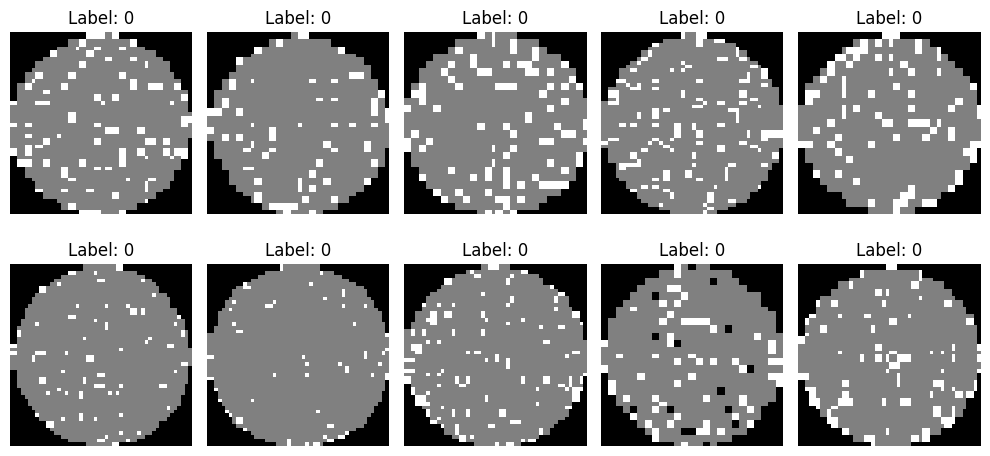

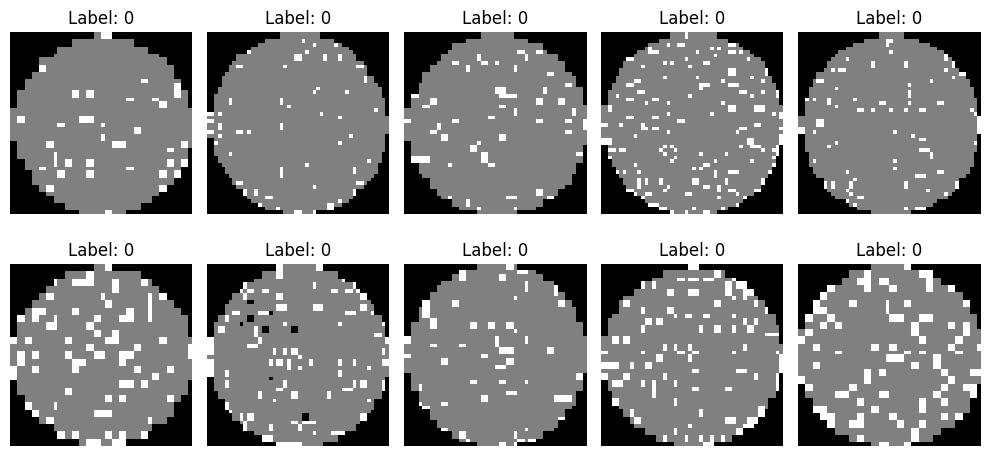

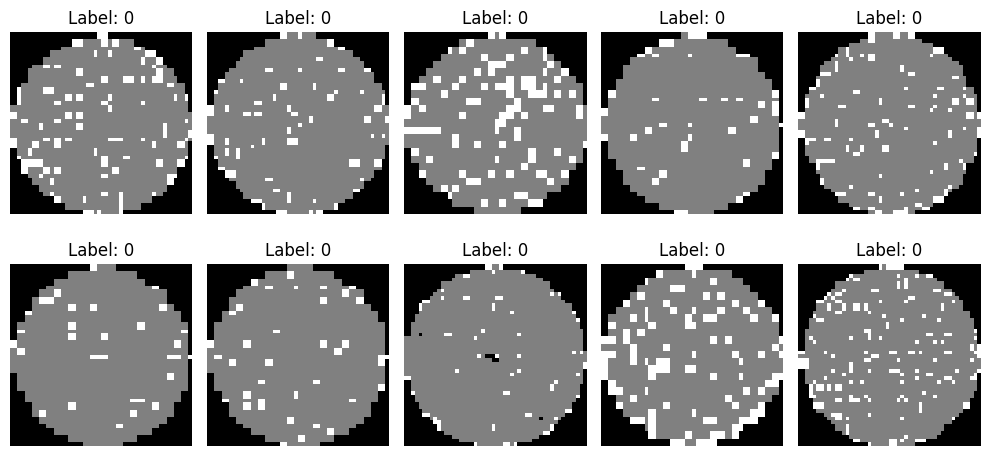

In [5]:
# Visualize first 10 images from the training set
plot_images(X_train, y_train, nrows=2, ncols=5)

# Visualize first 10 images from the validation set
plot_images(X_val, y_val, nrows=2, ncols=5)

# Visualize first 10 images from the test set
plot_images(X_test, y_test, nrows=2, ncols=5)

In [6]:
# Data got unshuffled -- need to reshuffle
def shuffle_data(x, y):
  tf.random.set_seed(1234)
  np.random.seed(1234)

  indices = np.random.permutation(len(x))
  x = x[indices]
  y = y[indices]

  return x, y

X_train, y_train = shuffle_data(X_train, y_train)
X_val, y_val = shuffle_data(X_val, y_val)
X_test, y_test = shuffle_data(X_test, y_test)

In [7]:
# SEQUENTIAL CNN MODEL
# def get_model(img_size, num_classes, kernel_size, activation):
#     np.random.seed(1234)
#     tf.random.set_seed(1234)

#     model = tf.keras.Sequential([
#         tf.keras.layers.Conv2D(32, (kernel_size, kernel_size), activation = activation),
#         tf.keras.layers.MaxPooling2D((2,2)),
#         tf.keras.layers.Conv2D(64, (kernel_size, kernel_size), activation = activation),
#         tf.keras.layers.MaxPooling2D((2,2)),
#         tf.keras.layers.Dropout(rate = 0.5),
#         tf.keras.layers.Conv2D(128, (kernel_size, kernel_size), activation = activation),
#         tf.keras.layers.MaxPooling2D((2,2)),
#         tf.keras.layers.Conv2D(256, (kernel_size, kernel_size), activation = activation),
#         tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(num_classes, activation = 'softmax')
#     ])

#     model.build(input_shape = (None,) + img_size + (1,))

#     return model


In [8]:
# FUNCTIONAL CNN MODEL
def get_model(img_size, num_classes, kernel_size, activation):
    np.random.seed(1234)
    tf.random.set_seed(1234)

    input_tensor = keras.Input(shape=img_size + (1,))

    conv_1 = layers.Conv2D(32, kernel_size=(kernel_size, kernel_size), activation=activation)(input_tensor)
    max_1 = layers.MaxPooling2D(pool_size=(2, 2))(conv_1)

    conv_2 = layers.Conv2D(64, kernel_size=(kernel_size, kernel_size), activation=activation)(max_1)
    max_2 = layers.MaxPooling2D(pool_size=(2, 2))(conv_2)

    conv_3 = layers.Conv2D(128, kernel_size=(kernel_size, kernel_size), activation=activation)(max_2)

    flat_1 = layers.Flatten()(conv_3)
    dropout_1 = layers.Dropout(0.5)(flat_1)
    output_tensor = layers.Dense(num_classes, activation='softmax')(dropout_1)

    model = keras.Model(input_tensor, output_tensor)
    return model

In [9]:
# FUNCTIONAL CNN WITH MORE PARAMETERS
# def get_model(img_size, num_classes, kernel_size, activation):
#     np.random.seed(1234)
#     tf.random.set_seed(1234)

#     input_tensor = keras.Input(shape=img_size + (1,))

#     conv_1 = layers.Conv2D(32, kernel_size=(kernel_size, kernel_size), activation=activation)(input_tensor)
#     max_1 = layers.MaxPooling2D(pool_size=(2, 2))(conv_1)
#     conv_2 = layers.Conv2D(64, kernel_size=(kernel_size, kernel_size), activation=activation)(max_1)
#     max_2 = layers.MaxPooling2D(pool_size=(2, 2))(conv_2)
#     conv_3 = layers.Conv2D(128, kernel_size=(kernel_size, kernel_size), activation=activation)(max_2)

#     flat_1 = layers.Flatten()(conv_3)
#     dense_1 = layers.Dense(512, activation = activation)(flat_1)
#     dense_2 = layers.Dense(128, activation = activation)(dense_1)
#     output_tensor = layers.Dense(num_classes, activation='softmax')(dense_2)

#     model = keras.Model(input_tensor, output_tensor)
#     return model

In [10]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(1234)
tf.random.set_seed(1234)
# Define image size and number of classes
img_size = (50, 50)
num_classes = 5
kernel_size = 5
activation = 'relu'

# Get the model
model = get_model(img_size=img_size, num_classes=num_classes, kernel_size = kernel_size, activation = activation)

# Compile the model
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=100,
    callbacks=[early_stopping],
    verbose=2
)

model.summary()

train_loss, train_acc = model.evaluate(X_train, y_train, verbose = 2)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose = 2)

print(f"Train accuracy: {train_acc: .3f}")
print(f"Val accuracy: {val_acc: .3f}")

Epoch 1/50
300/300 - 255s - 850ms/step - accuracy: 0.4464 - loss: 1.2383 - val_accuracy: 0.2368 - val_loss: 1.3065
Epoch 2/50
300/300 - 219s - 730ms/step - accuracy: 0.6004 - loss: 0.9657 - val_accuracy: 0.8547 - val_loss: 0.6610
Epoch 3/50
300/300 - 208s - 693ms/step - accuracy: 0.6637 - loss: 0.8014 - val_accuracy: 0.8880 - val_loss: 0.4788
Epoch 4/50
300/300 - 265s - 882ms/step - accuracy: 0.7011 - loss: 0.7229 - val_accuracy: 0.9237 - val_loss: 0.3748
Epoch 5/50
300/300 - 213s - 711ms/step - accuracy: 0.7236 - loss: 0.6759 - val_accuracy: 0.9111 - val_loss: 0.4203
Epoch 6/50
300/300 - 293s - 975ms/step - accuracy: 0.7419 - loss: 0.6397 - val_accuracy: 0.8998 - val_loss: 0.4384
Epoch 7/50
300/300 - 257s - 857ms/step - accuracy: 0.7503 - loss: 0.6089 - val_accuracy: 0.9335 - val_loss: 0.3538
Epoch 8/50
300/300 - 271s - 904ms/step - accuracy: 0.7632 - loss: 0.5842 - val_accuracy: 0.9456 - val_loss: 0.2870
Epoch 9/50
300/300 - 258s - 860ms/step - accuracy: 0.7716 - loss: 0.5647 - val_a

In [11]:
# train_loss, train_acc = model.evaluate(X_train, y_train, verbose = 2)
# val_loss, val_acc = model.evaluate(X_val, y_val, verbose = 2)

# print(f"Train accuracy: {train_acc: .3f}")
# print(f"Val accuracy: {val_acc: .3f}")

In [12]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose = 2)
print(f"Test accuracy: {test_acc: .3f}")

1064/1064 - 2s - 2ms/step - accuracy: 0.9531 - loss: 0.1857
Test accuracy:  0.953


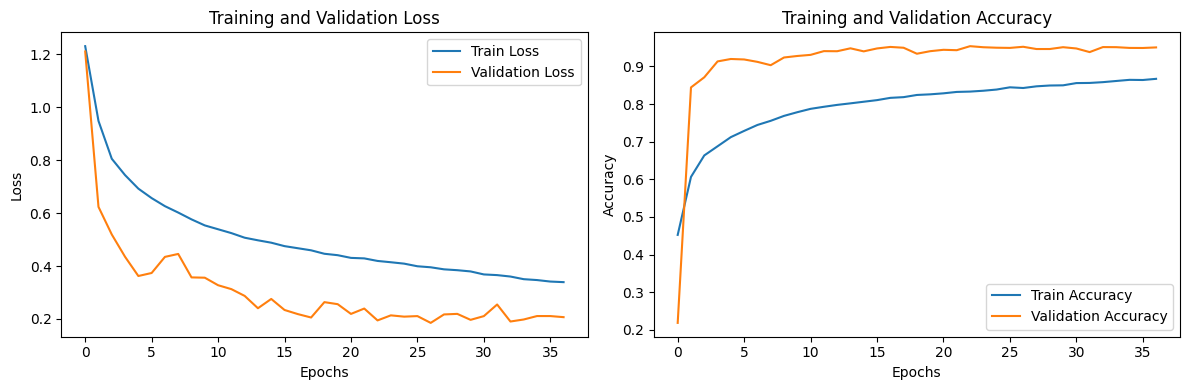

In [13]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

In [14]:
# Encode 'failureType' labels as integers for modeling
label_mapping = {
    'none': 0,
    'Center': 1,
    'Edge-Loc': 2,
    'Edge-Ring': 3,
    'Loc': 4

}

1064/1064 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


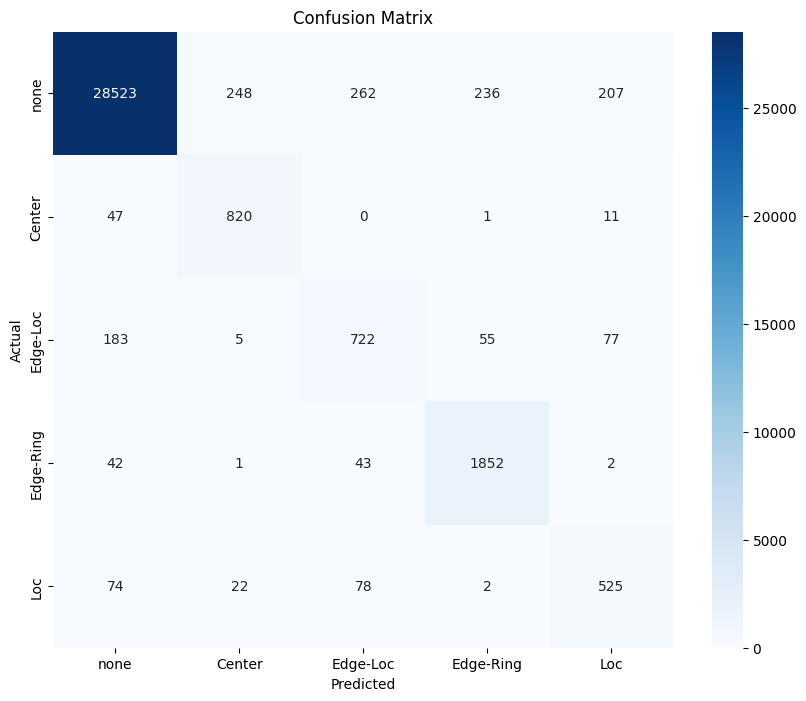

              precision    recall  f1-score   support

        none       0.99      0.97      0.98     29476
      Center       0.75      0.93      0.83       879
    Edge-Loc       0.65      0.69      0.67      1042
   Edge-Ring       0.86      0.95      0.91      1940
         Loc       0.64      0.75      0.69       701

    accuracy                           0.95     34038
   macro avg       0.78      0.86      0.82     34038
weighted avg       0.96      0.95      0.95     34038



In [15]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on test set
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(y_test, y_test_pred_classes, target_names=label_mapping.keys())
print(report)

**Precision** - measures the True Positives, compared how total the model predicted as positive (TP / TP + FP)

**Recall** - measures the correct identification of True Positives, compared to how many positives were actually there (TP / TP + FN)

**F1 Score** - Harmonic mean of precision and recall - how well our model correctly identifies (precision) and catching all positives that were there (Recall). If F1 is high, the model has a good balance between precision and recall. If low, the model may be favoring one or the other.

**Support** - The number of data the model was calculated on

**Accuracy** - How many items correctly classified

**Macro Average** - average precision, recall, and f1 scores between classes without taking into account class imbalance

**Weighted Average** - average taking into account class sizes

In [16]:
# Print the class distribution in the training set
unique, frequency = np.unique(y_test, return_counts=True)
class_distribution = dict(zip(unique, frequency))
print("Class Distribution:", class_distribution)

Class Distribution: {0: 29476, 1: 879, 2: 1042, 3: 1940, 4: 701}


In [17]:
# Encode 'failureType' labels as integers for modeling
label_mapping = {
    'none': 0,
    'Center': 1,
    'Edge-Loc': 2,
    'Edge-Ring': 3,
    'Loc': 4

}